<a href="https://colab.research.google.com/github/Jangho-Kim-1999/LNN/blob/main/LNN_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.4.33
    Uninstalling jax-cuda12-pjrt-0.4.33:
      Successfully uninstalled jax-cuda12-pjrt-0.4.33
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.4.33
    Unins

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

  if event.key is 'enter':

  print(xla_bridge.get_backend().platform)



gpu


In [ ]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [ ]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2

  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)


In [ ]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [ ]:
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch #targets: x_train, xt_train = ((q, qdot)(qdot, qddot))
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

In [ ]:
time_step = 0.01
N = 1500
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32) # time steps 0 to N
%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step

CPU times: user 13.4 s, sys: 19.1 ms, total: 13.4 s
Wall time: 15.4 s
CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 568 ms
CPU times: user 565 ms, sys: 0 ns, total: 565 ms
Wall time: 769 ms
CPU times: user 14.5 s, sys: 0 ns, total: 14.5 s
Wall time: 14.5 s
CPU times: user 32.7 ms, sys: 0 ns, total: 32.7 ms
Wall time: 25.4 ms
CPU times: user 1.06 ms, sys: 0 ns, total: 1.06 ms
Wall time: 747 µs


In [ ]:
# Upload files
from google.colab import files
import os

uploaded = files.upload()

# Load Train and Test Data
trains_loaded = np.load("LNN_trains.npz")
tests_loaded = np.load("LNN_tests.npz")

# Verify keys in the saved files
print("Train Set Keys:", trains_loaded.files)
print("Test Set Keys:", tests_loaded.files)

# Convert NumPy arrays back to JAX
x_train = jnp.array(trains_loaded["x_train"])
xt_train = jnp.array(trains_loaded["xt_train"])
y_train = jnp.array(trains_loaded["y_train"])

x_test = jnp.array(tests_loaded["x_test"])
xt_test = jnp.array(tests_loaded["xt_test"])
y_test = jnp.array(tests_loaded["y_test"])

print("Train and test sets successfully loaded as JAX arrays!")
print("Train Shapes:", x_train.shape, xt_train.shape, y_train.shape)
print("Test Shapes:", x_test.shape, xt_test.shape, y_test.shape)


Saving LNN_tests.npz to LNN_tests.npz
Saving LNN_trains.npz to LNN_trains.npz
Train Set Keys: ['x_train', 'xt_train', 'y_train']
Test Set Keys: ['x_test', 'xt_test', 'y_test']
Train and test sets successfully loaded as JAX arrays!
Train Shapes: (1500, 4) (1500, 4) (1500, 4)
Test Shapes: (1500, 4) (1500, 4) (1500, 4)


In [ ]:
time_step = 0.01
N = 1500

@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

In [ ]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params_LNN_new = get_params(opt_state)

iteration=0, train_loss=263.950867, test_loss=271.102509
iteration=1000, train_loss=183.722931, test_loss=193.533997
iteration=2000, train_loss=183.722931, test_loss=193.533997
iteration=3000, train_loss=183.722916, test_loss=193.533951
iteration=4000, train_loss=183.722916, test_loss=193.533936
iteration=5000, train_loss=183.722870, test_loss=193.533875
iteration=6000, train_loss=183.722794, test_loss=193.533783
iteration=7000, train_loss=183.722672, test_loss=193.533630
iteration=8000, train_loss=183.722366, test_loss=193.533249
iteration=9000, train_loss=183.721893, test_loss=193.532623
iteration=10000, train_loss=183.720901, test_loss=193.531326
iteration=11000, train_loss=183.719040, test_loss=193.528931
iteration=12000, train_loss=183.715622, test_loss=193.524582
iteration=13000, train_loss=183.709671, test_loss=193.516922
iteration=14000, train_loss=183.699295, test_loss=193.503540
iteration=15000, train_loss=183.680389, test_loss=193.479263
iteration=16000, train_loss=183.64845

In [ ]:
######## only NN #########
def learned_NN(params_NN):
  def output_NN(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    q_tt = nn_forward_fn_NN(params_NN, state)
    return q_tt
  return output_NN

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss_NN(params, batch, time_step=None):
  state, targets = batch  #state = (q, qdot) targets = (qdot, qddot)
  targets = targets[:,2:]

  preds_fn = learned_NN(params)  # This is a function
  preds = jax.vmap(preds_fn)(state[:, :2], state[:, 2:])  # Compute predictions

  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params_NN, nn_forward_fn_NN = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(2),
)

In [ ]:
@jax.jit
def update_timestep_NN(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss_NN)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative_NN(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss_NN)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
xt_train = jax.device_put(jax.vmap(normalize_dp)(xt_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
xt_test = jax.device_put(jax.vmap(normalize_dp)(xt_test))
y_test = jax.device_put(y_test)

In [ ]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params_NN = init_random_params_NN(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses_NN = []
test_losses_NN = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params_NN)

for iteration in range(150001):
  if iteration % batch_size == 0:
    params = get_params(opt_state)

    train_loss_NN = loss_NN(params, (x_train, xt_train))
    train_losses_NN.append(train_loss_NN)
    test_loss_NN = loss_NN(params, (x_test, xt_test))
    test_losses_NN.append(test_loss_NN)


    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss_NN:.6f}, test_loss={test_loss_NN:.6f}")
  opt_state = update_derivative_NN(iteration, opt_state, (x_train, xt_train))

params_NN = get_params(opt_state)

iteration=0, train_loss=313.442413, test_loss=321.995331
iteration=1000, train_loss=4.679827, test_loss=6.908043
iteration=2000, train_loss=1.868687, test_loss=3.080214
iteration=3000, train_loss=0.997889, test_loss=1.890311
iteration=4000, train_loss=0.651250, test_loss=1.389320
iteration=5000, train_loss=0.483540, test_loss=1.182345
iteration=6000, train_loss=0.377273, test_loss=1.054914
iteration=7000, train_loss=0.305214, test_loss=0.987308
iteration=8000, train_loss=0.254456, test_loss=0.913264
iteration=9000, train_loss=0.217649, test_loss=0.857933
iteration=10000, train_loss=0.190834, test_loss=0.831656
iteration=11000, train_loss=0.167829, test_loss=0.799712
iteration=12000, train_loss=0.150689, test_loss=0.781991
iteration=13000, train_loss=0.139184, test_loss=0.754749
iteration=14000, train_loss=0.124942, test_loss=0.743338
iteration=15000, train_loss=0.116792, test_loss=0.739100
iteration=16000, train_loss=0.108059, test_loss=0.707988
iteration=17000, train_loss=0.101101, te

In [ ]:
# Convert JAX parameters to NumPy format
params_np_NN = jax.tree_util.tree_map(np.array, params_NN)

# Flatten the JAX parameter tree
params_flat, tree_def = jax.tree_util.tree_flatten(params_np_NN)

# Save each parameter separately
params_dict_NN = {f"param_{i}": param for i, param in enumerate(params_flat)}

# Also save the tree structure (needed for restoring)
params_dict_NN["tree_def"] = tree_def

# Save to a file
np.savez("params_NN.npz", **params_dict_NN)

# Download the file
files.download("params_NN.npz")

print("✅ Parameters saved successfully as params_NN.npz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Parameters saved successfully as params_NN.npz


In [ ]:
# Upload file
uploaded = files.upload()

# Load parameters from the npz file
params_loaded = np.load("params_NN.npz", allow_pickle=True)

# Print available parameter keys for debugging
print("Keys in saved parameters:", params_loaded.files)

# Restore the tree structure
tree_def = params_loaded["tree_def"].item()  # Extract tree structure

# Restore individual parameters
params_flat = [params_loaded[f"param_{i}"] for i in range(len(params_loaded.files) - 1)]  # Exclude "tree_def"

# Convert back to JAX format
params_NN_upload = jax.tree_util.tree_unflatten(tree_def, params_flat)

print("✅ Params successfully loaded as JAX arrays!")

# Example: Print the shape of each parameter
for i, param in enumerate(jax.tree_util.tree_leaves(params_NN_upload)):
    print(f"Parameter {i} shape: {param.shape}")


Saving params_NN.npz to params_NN (1).npz
Keys in saved parameters: ['param_0', 'param_1', 'param_2', 'param_3', 'param_4', 'param_5', 'tree_def']
✅ Params successfully loaded as JAX arrays!
Parameter 0 shape: (4, 128)
Parameter 1 shape: (128,)
Parameter 2 shape: (128, 128)
Parameter 3 shape: (128,)
Parameter 4 shape: (128, 2)
Parameter 5 shape: (2,)


In [ ]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# # replace the lagrangian with a parameteric model
# def learned_lagrangian(params):
#   def lagrangian(state):
#     q, q_t = jnp.split(state, 2)
#     assert q.shape == (2,)
#     # state = normalize_dp(jnp.concatenate([q, q_t]))
#     return nn_forward_fn(params, state)
#   return lagrangian

In [ ]:
print(params_LNN_upload)

[(array([[ 1.06838588e-02, -4.98846769e-01, -3.71336997e-01,
        -9.97820124e-02, -8.42880160e-02,  6.71407580e-01,
         1.66064486e-01,  3.99705887e-01, -1.78138807e-01,
         4.99049537e-02,  6.58694878e-02,  2.53125783e-02,
        -5.10477841e-01, -1.28371298e-01,  1.08589068e-01,
         2.09242702e-01, -6.31065905e-01, -1.69913411e-01,
         3.64122838e-01,  3.32478173e-02, -3.25742543e-01,
         9.15874075e-03,  6.30389526e-02, -1.72708139e-01,
        -1.09684639e-01,  1.19745098e-01,  1.48869241e-02,
        -7.55259916e-02,  5.80284186e-02, -5.24163395e-02,
         7.71333510e-03,  1.23584434e-01, -4.56672199e-02,
         9.23306704e-01,  4.08610463e-01,  1.42965317e-01,
         1.01490986e+00,  5.44895604e-02,  2.15141073e-01,
         1.46037757e-01,  2.47563422e-01,  1.27620447e+00,
        -1.48635104e-01,  3.82087519e-03,  2.97540147e-02,
        -2.92500500e-02,  7.51531124e-02,  8.81006420e-02,
        -4.58597720e-01,  2.77037948e-01, -5.98188676e

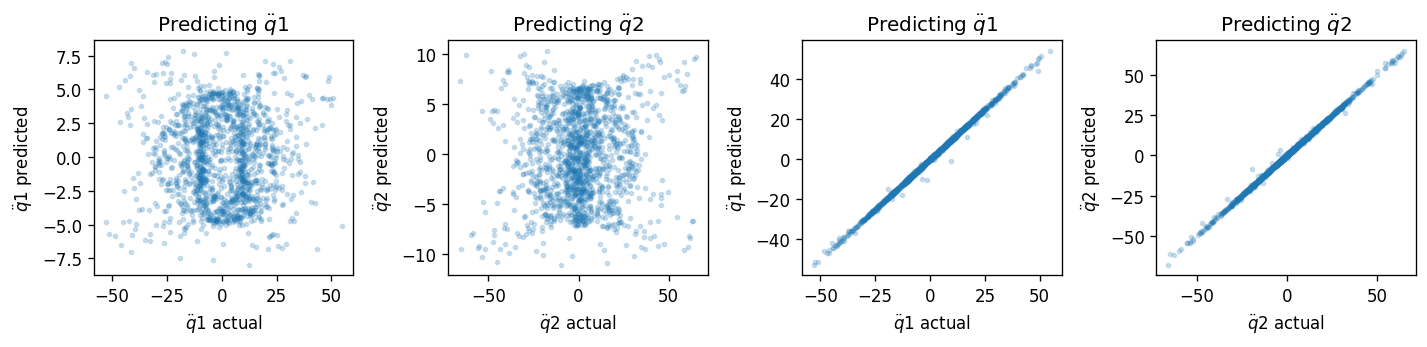

In [ ]:
# lagrangian_fn = learned_lagrangian(params_LNN)  # Ensure this is correctly returned
# xt_pred_LNN = jax.vmap(lambda state: equation_of_motion(lagrangian_fn, state))(x_test)

xt_pred_LNN = jax.vmap(partial(equation_of_motion, learned_lagrangian(params_LNN_new)))(x_test)

preds_fn = learned_NN(params_NN_upload)  # This is a function
xt_pred_NN = jax.vmap(preds_fn)(x_test[:, :2],x_test[:, 2:])  # Compute predictions

fig, axes = plt.subplots(1, 4, figsize=(12, 3), dpi=120)

axes[0].scatter(xt_test[:, 2], xt_pred_LNN[:, 0], s=6, alpha=0.2)
axes[0].set_title('Predicting $\ddot q1$')
axes[0].set_xlabel('$\ddot q1$ actual')
axes[0].set_ylabel('$\ddot q1$ predicted')
axes[1].scatter(xt_test[:, 3], xt_pred_LNN[:, 1], s=6, alpha=0.2)
axes[1].set_title('Predicting $\ddot q2$')
axes[1].set_xlabel('$\ddot q2$ actual')
axes[1].set_ylabel('$\ddot q2$ predicted')

axes[2].scatter(xt_test[:, 2], xt_pred_NN[:, 0], s=6, alpha=0.2)
axes[2].set_title('Predicting $\ddot q1$')
axes[2].set_xlabel('$\ddot q1$ actual')
axes[2].set_ylabel('$\ddot q1$ predicted')
axes[3].scatter(xt_test[:, 3], xt_pred_NN[:, 1], s=6, alpha=0.2)
axes[3].set_title('Predicting $\ddot q2$')
axes[3].set_xlabel('$\ddot q2$ actual')
axes[3].set_ylabel('$\ddot q2$ predicted')

plt.tight_layout()

CPU times: user 57.4 ms, sys: 996 µs, total: 58.4 ms
Wall time: 65.5 ms
CPU times: user 2.9 s, sys: 97.4 ms, total: 3 s
Wall time: 2.48 s
CPU times: user 338 ms, sys: 0 ns, total: 338 ms
Wall time: 327 ms


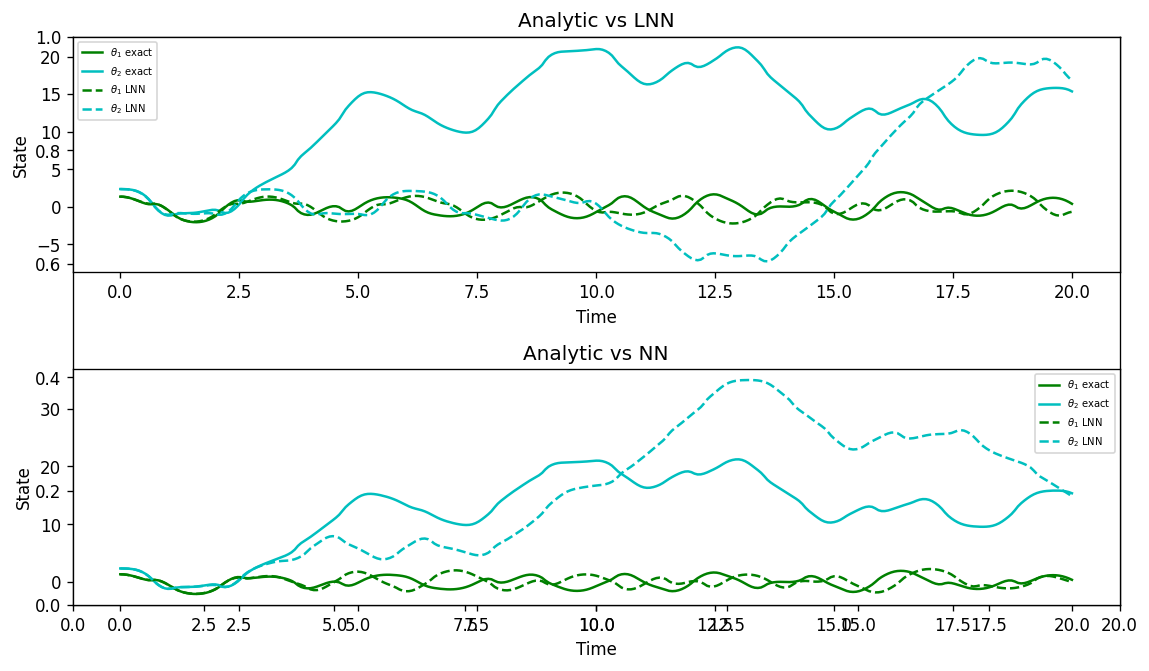

In [ ]:
#시간에 대한 함수로 나타내자.
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t2 = np.linspace(0, 20, num=301)

%time x1_analytical = jax.device_get(solve_analytical(x1, t2))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params_LNN), x1, t=t2))

#NN 시간에 대한 함수로 나타내야함
%time NN_model = jax.device_get(solve_NN(x1,t2))

plt.figure(figsize=[10,6], dpi=120) ; plt.xlim(0, 20)
plt.subplot(2,1,1)
plt.title("Analytic vs LNN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 1], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 0], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_model[:, 1], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)


plt.subplot(2,1,2)
plt.title("Analytic vs NN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 1], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, NN_model[:, 0], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, NN_model[:, 1], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

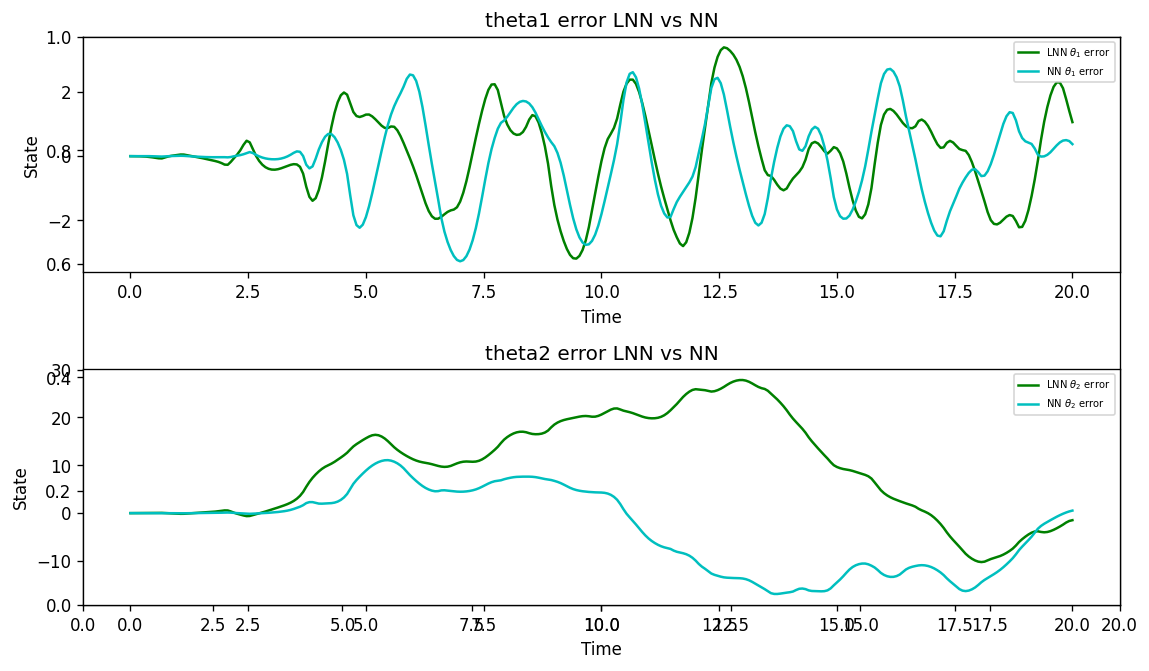

In [ ]:
#성능평가 Error 비교

plt.figure(figsize=[10,6], dpi=120) ; plt.xlim(0, 20)

plt.subplot(2,1,1)
plt.title("theta1 error LNN vs NN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0]-x1_model[:, 0], 'g-', label=r'LNN $\theta_1$ error')
plt.plot(t2, x1_analytical[:, 0]-NN_model[:, 0], 'c-', label=r'NN $\theta_1$ error')
plt.legend(fontsize=6)

plt.subplot(2,1,2)
plt.title("theta2 error LNN vs NN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 1]-x1_model[:, 1], 'g-', label=r'LNN $\theta_2$ error')
plt.plot(t2, x1_analytical[:, 1]-NN_model[:, 1], 'c-', label=r'NN $\theta_2$ error')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

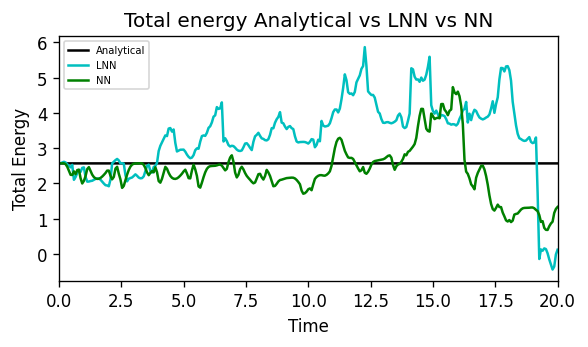

In [ ]:
#성능평가 Total Energy 비교
def tot_energy(state, m1, m2, l1, l2, g):
  t1, t2, w1, w2 = jnp.split(state, 4, axis = 1)
  # t1, t2 = q     # theta 1 and theta 2
  # w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2

  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2
  return T + V

Analy_tot_energy = jnp.squeeze(tot_energy(x1_analytical, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1)
NN_tot_energy = jnp.squeeze(tot_energy(x1_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1)
LNN_tot_energy = jnp.squeeze(tot_energy(NN_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1)


plt.figure(figsize=[5,3], dpi=120) ; plt.xlim(0, 20)

plt.title("Total energy Analytical vs LNN vs NN")
plt.xlabel("Time") ; plt.ylabel("Total Energy")
plt.plot(t2, Analy_tot_energy, 'k-', label=r'Analytical')
plt.plot(t2, LNN_tot_energy, 'c-', label=r'LNN')
plt.plot(t2, NN_tot_energy, 'g-', label=r'NN')

plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()